# Double Jet

ML scores over simulation time

In [1]:
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt

plt.style.use('dark_background')

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.DoubleJetPlot import *

Get initial arguments from class

In [4]:
from gpuocean.utils import DoubleJetCase

In [5]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=256, nx=512)
doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

## MLMC

In [6]:
MLMCsource_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/MLMC/2023-10-27T14_52_13"

In [7]:
Ts = np.load(MLMCsource_path+"/MLts.npy")

In [8]:
MLMCrmse = np.load(MLMCsource_path+"/MLrmses.npy")
MLMCstd = np.load(MLMCsource_path+"/MLstddevs.npy")

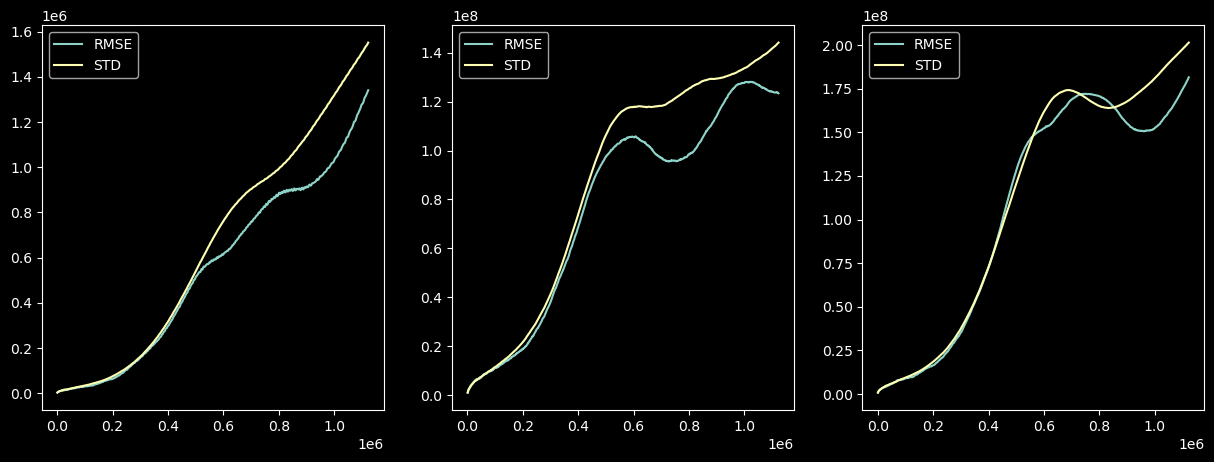

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i in range(3):
    axs[i].plot(Ts, MLMCrmse[:,i], label="RMSE")
    axs[i].plot(Ts, MLMCstd[:,i], label="STD")
    axs[i].legend()

In [10]:
MLMCscores = np.load(MLMCsource_path+"/MLscores.npy")
MLMCdiff_scores = np.load(MLMCsource_path+"/MLdiff_scores.npy")

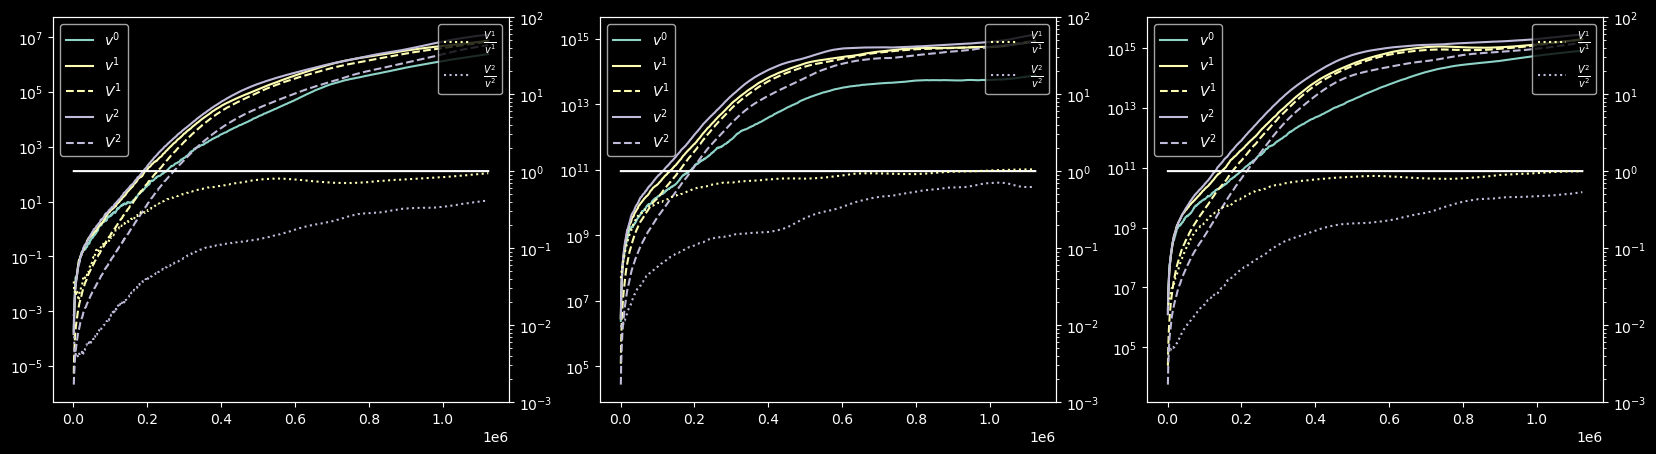

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))

for i in range(3):
    for l_idx in range(3):
        axs[i].plot(Ts, MLMCscores[:,l_idx,i], label=r"$v^"+str(l_idx)+"$", c="C"+str(l_idx))
        if l_idx > 0:
            axs[i].plot(Ts, MLMCdiff_scores[:,l_idx,i], label=r"$V^"+str(l_idx)+"$", ls="--", c="C"+str(l_idx))
    axs[i].legend()
    axs[i].set_yscale("log")

    ax = axs[i].twinx() 
    ax.plot(Ts, np.ones_like(Ts), c="white")
    for l_idx in range(1, 3):
        ax.plot(Ts,  MLMCdiff_scores[:,l_idx,i]/MLMCscores[:,l_idx,i], ls="dotted", c="C"+str(l_idx), label=r"$\frac{V^"+str(l_idx)+"}{v^"+str(l_idx)+"}$")
    ax.legend()
    ax.set_yscale("log")
    ax.set_ylim((1e-3, 1e2))

## MLDA

In [12]:
MLDAsource_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/MLDA/2023-10-30T11_39_40"

In [13]:
Ts = np.load(MLDAsource_path+"/MLts_posterior.npy")

In [14]:
rmse_prior = np.load(MLDAsource_path+"/MLrmses_prior.npy")
std_prior = np.load(MLDAsource_path+"/MLstddevs_prior.npy")

rmse_posterior = np.load(MLDAsource_path+"/MLrmses_posterior.npy")
std_posterior = np.load(MLDAsource_path+"/MLstddevs_posterior.npy")

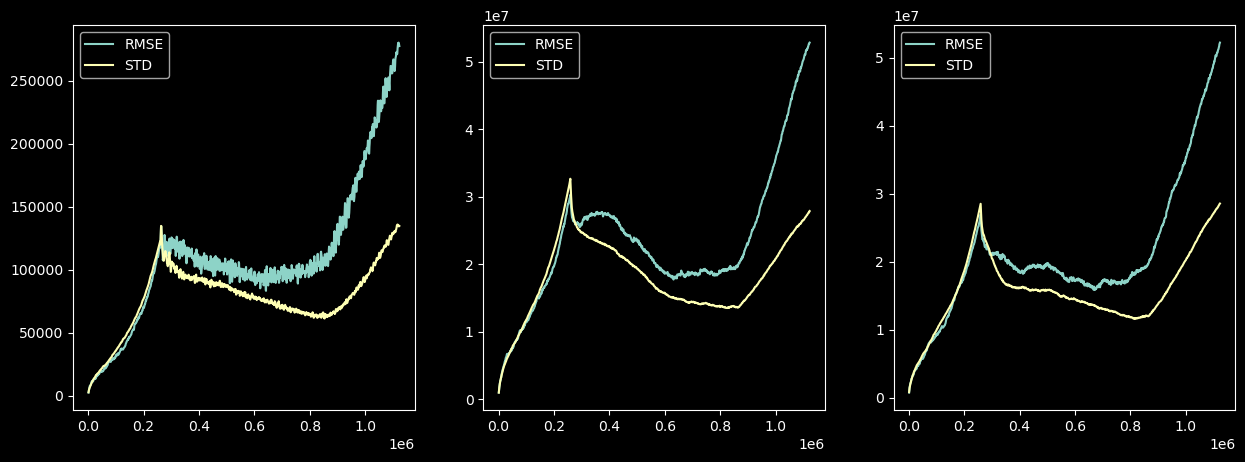

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i in range(3):
    axs[i].plot(Ts, rmse_posterior[:,i], label="RMSE")
    axs[i].plot(Ts, std_posterior[:,i], label="STD")
    axs[i].legend()

SL reference 

In [16]:
SLDAsource_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/SLDA/2023-11-03T10_21_42"

In [17]:
SL_rmse = np.load(SLDAsource_path+"/rmse.npy")
SL_std = np.load(SLDAsource_path+"/stddev.npy")

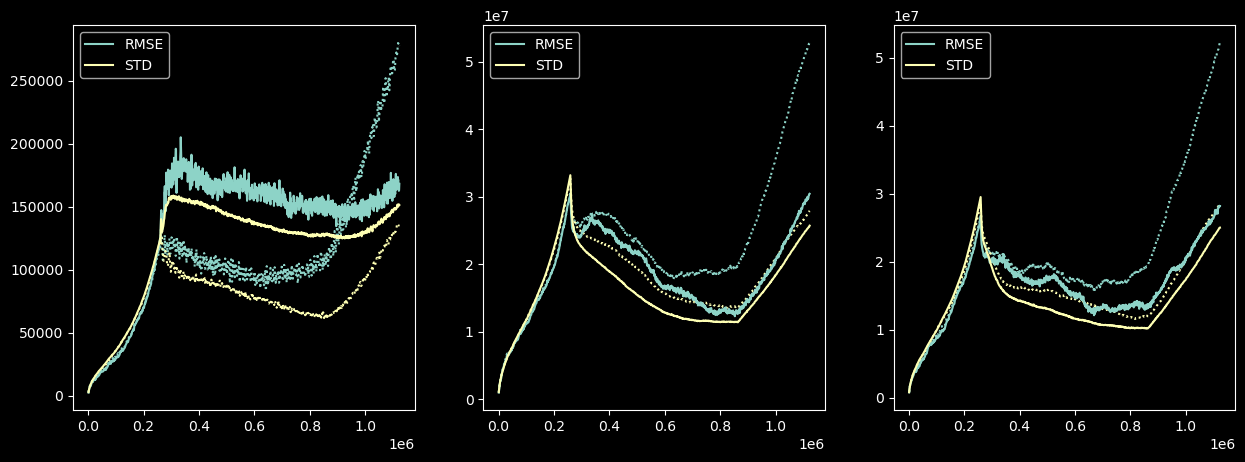

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i in range(3):
    axs[i].plot(Ts, rmse_posterior[:,i], ls="dotted", c="C0")
    axs[i].plot(Ts, std_posterior[:,i], ls="dotted", c="C1")
    axs[i].plot(Ts, SL_rmse[:,i], label="RMSE", c="C0")
    axs[i].plot(Ts, SL_std[:,i], label="STD", c="C1")
    axs[i].legend()

ML eligibility scores

In [19]:
MLDAscores_prior = np.load(MLDAsource_path+"/MLscores_prior.npy")
MLDAdiff_scores_prior = np.load(MLDAsource_path+"/MLdiff_scores_prior.npy")

MLDAscores_posterior = np.load(MLDAsource_path+"/MLscores_posterior.npy")
MLDAdiff_scores_posterior = np.load(MLDAsource_path+"/MLdiff_scores_posterior.npy")

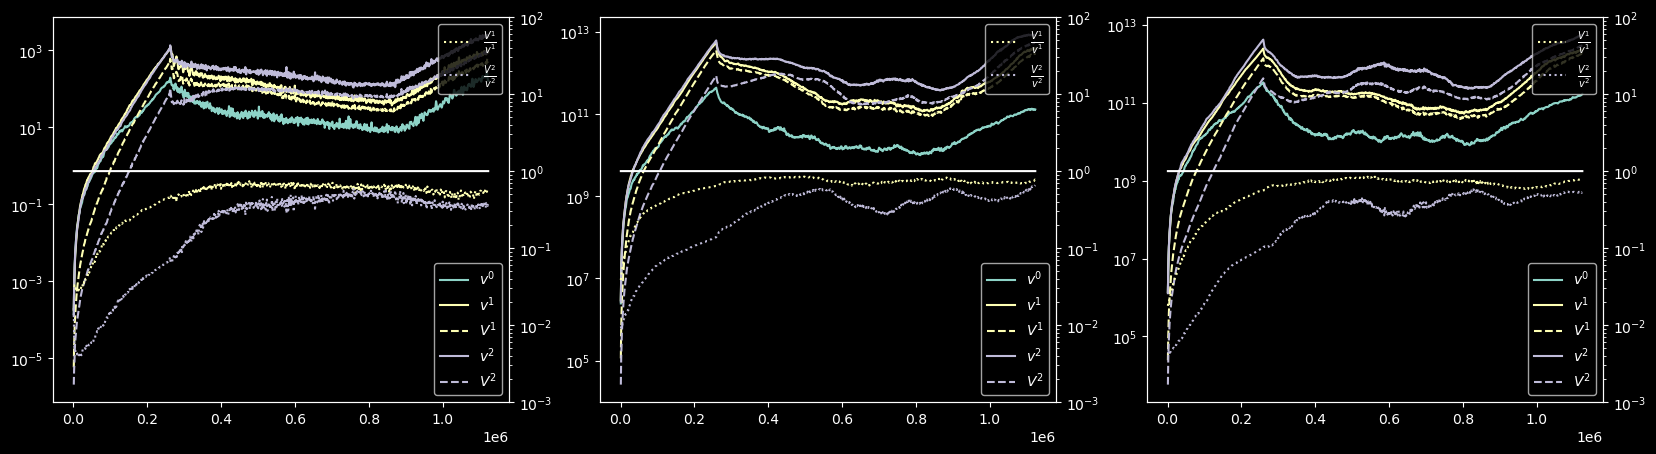

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))

for i in range(3):
    for l_idx in range(len(MLDAscores_posterior[0])):
        axs[i].plot(Ts, MLDAscores_posterior[:,l_idx,i], label=r"$v^"+str(l_idx)+"$", c="C"+str(l_idx))
        if l_idx > 0:
            axs[i].plot(Ts, MLDAdiff_scores_posterior[:,l_idx,i], label=r"$V^"+str(l_idx)+"$", ls="--", c="C"+str(l_idx))
    axs[i].legend()
    axs[i].set_yscale("log")

    ax = axs[i].twinx() 
    ax.plot(Ts, np.ones_like(Ts), c="white")
    for l_idx in range(1, len(MLDAscores_posterior[0])):
        ax.plot(Ts,  MLDAdiff_scores_posterior[:,l_idx,i]/MLDAscores_posterior[:,l_idx,i], ls="dotted", c="C"+str(l_idx), label=r"$\frac{V^"+str(l_idx)+"}{v^"+str(l_idx)+"}$")
    ax.legend()
    ax.set_yscale("log")
    ax.set_ylim((1e-3, 1e2))

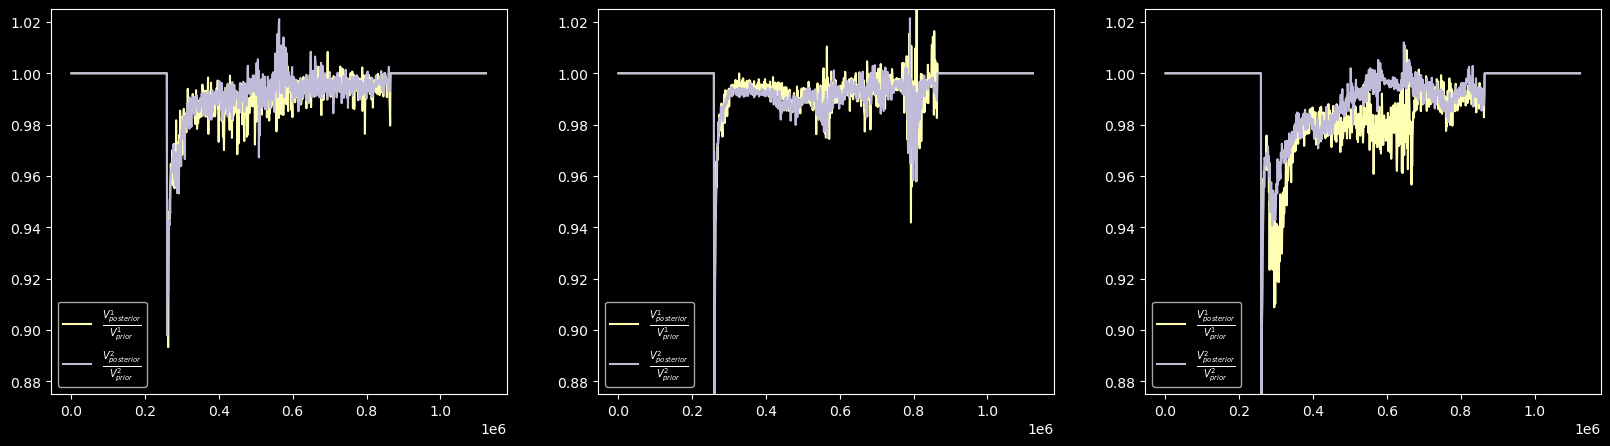

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))

for i in range(3):
    for l_idx in range(len(MLDAscores_posterior[0])):
        if l_idx > 0:
            axs[i].plot(Ts, MLDAscores_posterior[:,l_idx,i]/MLDAscores_prior[:,l_idx,i], label=r"$\frac{V_{posterior}^"+str(l_idx)+"}{V_{prior}^"+str(l_idx)+"}$", c="C"+str(l_idx))
    axs[i].legend()
    axs[i].set_ylim((0.875, 1.025))

In [22]:
Ts/3600/24

array([1.04166667e-02, 2.08333333e-02, 3.12500000e-02, ...,
       1.29791667e+01, 1.29895833e+01, 1.30000000e+01])

Text(0.5, 0.98, 'MC: dotted, DA: solid')

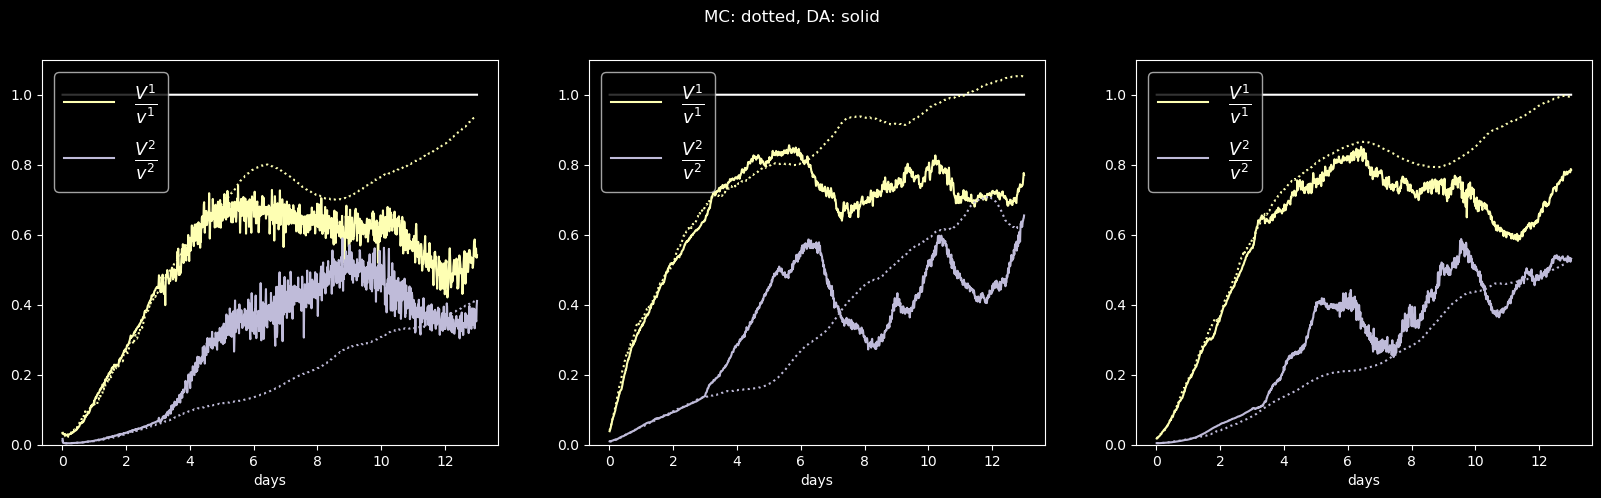

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))

for i in range(3):
    axs[i].plot(Ts/3600/24, np.ones_like(Ts), c="white")
    for l_idx in range(1, len(MLDAscores_posterior[0])):
        axs[i].plot(Ts/3600/24,  MLDAdiff_scores_posterior[:,l_idx,i]/MLDAscores_posterior[:,l_idx,i], c="C"+str(l_idx), label=r"$\frac{V^"+str(l_idx)+"}{v^"+str(l_idx)+"}$")
        axs[i].plot(Ts/3600/24,  MLMCdiff_scores[:,l_idx,i]/MLMCscores[:,l_idx,i], ls="dotted", c="C"+str(l_idx))
    axs[i].legend(fontsize=18, loc=2)
    # axs[i].set_yscale("log")
    axs[i].set_ylim((0.0, 1.1))
    axs[i].set_xlabel("days")

fig.suptitle("MC: dotted, DA: solid")
